<h1 align="center">ECE 176 Project</h1>

# Table of Contents

1. Dataset Preparation: we will implement an American Sign Language (ASL) alphabet library.
2. Model: create a neural network architecture for our dataset.
3. Finetuning: find ways to improve the model.
4. Test/Visuals: create tests and look at which ASL letters were best recognized and why.
5. Conclusion/Discussion: discussion of results and possible further study.



## Acknowledgements
https://www.kaggle.com/grassknoted/aslalphabet_akash nagaraj_2018,
#### ASL Alphabet
https://www.kaggle.com/dsv/29550
10.34740/KAGGLE/DSV/29550


# Dataset Preparation

Initially, we will focus on implementing an American Sign Language (ASL) alphabet library. This involves loading the ASL alphabet dataset, a step that may require a few minutes upon the first attempt. Subsequently, the data will be cached, ensuring quicker access in future sessions. 


In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 

# ensure consistency across runs
from numpy.random import seed
import numpy as np
from torch.utils.data import DataLoader, random_split


### CustomImageDataset
Using the pytorch example and taking inspiration from previous assignment, below is the class created for uploading the training and testing datasets to pytorch.

In [39]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None, mode='train'):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.mode = mode
        self.img_labels = self._get_image_labels()


    def _get_image_labels(self):
        img_labels = []
        if self.mode == 'train':
            label = 0
            for root, dirs, files in os.walk(self.img_dir):
                for subdir in sorted(dirs):
                    subdir_path = os.path.join(root, subdir)
                    for _, _, files in os.walk(subdir_path):
                        for file in files:
                            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                                img_labels.append((os.path.join(subdir, file), label))
                    label += 1
        elif self.mode == 'test':
            for root, _, files in os.walk(self.img_dir):
                for file in files:
                    if file.lower().endswith(('png', 'jpg', 'jpeg')):
                        img_labels.append((file, None))
        return img_labels

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        img_path = os.path.join(self.img_dir, img_path)
        image = Image.open(img_path).convert('RGB')  # Use PIL to open image
        if self.transform:
            image = self.transform(image)
        if self.target_transform and label is not None:
            label = self.target_transform(label)
        return image, label
    


class CustomImageDatasetSkele(Dataset):
    def __init__(self, img_dir, skeleton_dir, transform=None, target_transform=None, mode='train'):
        self.img_dir = img_dir
        self.skeleton_dir = skeleton_dir
        self.transform = transform
        self.target_transform = target_transform
        self.mode = mode
        self.img_labels = self._get_image_labels()

    def _get_image_labels(self):
        img_labels = []
        if self.mode == 'train':
            label = 0
            for root, dirs, files in os.walk(self.img_dir):
                for subdir in sorted(dirs):
                    subdir_path = os.path.join(root, subdir)
                    for _, _, files in os.walk(subdir_path):
                        for file in files:
                            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                                img_labels.append((os.path.join(subdir, file), label))
                    label += 1
        elif self.mode == 'test':
            for root, _, files in os.walk(self.img_dir):
                for file in files:
                    if file.lower().endswith(('png', 'jpg', 'jpeg')):
                        img_labels.append((file, None))
        return img_labels

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        full_img_path = os.path.join(self.img_dir, img_path)
        skeleton_path = os.path.join(self.skeleton_dir, img_path)  # Adjust if the structure is different

        image = Image.open(full_img_path).convert('RGB')
        skeleton = Image.open(skeleton_path).convert('L')
        
        # Stack the grayscale image as an additional channel to create a 4-channel image
        combined_image = Image.merge("RGBA", image.split() + (skeleton,))

        if self.transform:
            combined_image = self.transform(combined_image)

        if self.target_transform and label is not None:
            label = self.target_transform(label)

        return combined_image, label

# Default Training/Test Set

Below is a list of the directories used for storing the datasets.

In [40]:
### User, Yann or Sebastian ###

image_size = (200,200)

username = input("Yann or Sebastian? Enter your name as seen here")
print('You are currently in', username,'s path')

if username == 'Yann':
    img_directory='/home/ybaglinbunod/private/unchanged_train/asl_alphabet_train/asl_alphabet_train'
    img_directory2='/home/ybaglinbunod/private/unchanged_train/asl_alphabet_test/asl_alphabet_test'
    img_dir='/home/ybaglinbunod/private/unchanged_test'
    img_skeleton='/home/ybaglinbunod/private/skeletonfolder/skeletonimages'
else:
    img_directory='/home/sdcastaneda/private/asl_alphabet_train/asl_alphabet_train'
    img_directory2='/home/sdcastaneda/private/asl_alphabet_test/asl_alphabet_test'
    
print(img_directory)
###############################



Yann or Sebastian? Enter your name as seen hereYann
You are currently in Yann s path
/home/ybaglinbunod/private/unchanged_train/asl_alphabet_train/asl_alphabet_train


## New Test Set

this transforms all of our training and testing datasets to tensors.

In [42]:
train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])





In [43]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


# Create data loaders for the training and validation sets
train_datasetskeleton = CustomImageDatasetSkele(
    img_dir= img_directory, 
    skeleton_dir = img_skeleton,
    #skeleton_dir ='/home/sdcastaneda/skeleton/skeletonimages',
    transform=train_transform,
    mode='train'
)

transform = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor()])

# Calculate the sizes for training and validation sets
train_size = int(0.9 * len(train_datasetskeleton))
val_size = len(train_datasetskeleton) - train_size

# Split the dataset
train_data, test_data = random_split(train_datasetskeleton, [train_size, val_size])




## Testing image dataset
###Below is a list of the images from the test dataset

In [44]:
# write code for displaying the test images here:

# Testing
#for i in range(0, len(dataset), 30):  # Adjust step to 30 to get one image per class
#    image, label = dataset[i]
#    image = transforms.ToPILImage()(image)
#    plt.imshow(image)
#    plt.title(f'Label: {label}')
#    plt.axis('off')  # This hides the axis ticks and labels
#    plt.show()
#    
#for i in range(len(dataset)):
#    image, label = dataset[i]
#    if image.size(1) != 200 or image.size(2) != 200:
#        print(f"Image {i} has a different size: {image.size()}")

## Training Dataset

#### Train Dataset has a length of 87,000 images
#### These images are 200x200, 29 classes, 26 for A-Z 3 for SPACE, DELETE, and NOTHING


In [45]:
#for i in range (0,len(train_dataset),3000):
#    image, label = train_dataset[i]
#    image = transforms.ToPILImage()(image)
#    plt.imshow(image)
#    plt.title(f'Label: {label}')
#    plt.axis('off')  # This hides the axis ticks and labels
#    plt.show()

## Default Test Dataset

In [46]:
#for i in range (0,len(test_dataset)):
#    image, label = test_dataset[i]
#    image = transforms.ToPILImage()(image)
#    plt.imshow(image)
#    plt.title(f'Label: {label}')
#    plt.axis('off')  # This hides the axis ticks and labels
#    plt.show()

## Data Loading
### we have two train dataset: one with the skeleton images and one without.

In [47]:
final_test = DataLoader(test_data, batch_size=64, shuffle=False)  
train_dataloaderskeleton = DataLoader(train_data, batch_size=64, shuffle=True)

In [48]:
USE_GPU = True
num_class = 29
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


# Classification Functions

In [49]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: 
    - A tuple of (final accuracy, iterations, losses) where:
      - final accuracy is the accuracy of the model after the final epoch
      - iterations is a list of iteration numbers
      - losses is a list of losses corresponding to the iterations
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    iterations = []
    losses = []
    current_iteration = 0

    for e in range(epochs):
        for t, (x, y) in enumerate(train_dataloaderskeleton):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (t + 1) % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t + 1, loss.item()))
                check_accuracy_part34(final_test, model)
                print()

            # Store the current iteration and loss for plotting
            current_iteration += 1
            iterations.append(current_iteration)
            losses.append(loss.item())

    final_accuracy = check_accuracy_part34(final_test, model)
    return final_accuracy, iterations, losses


In [50]:
def check_accuracy_part34(loader, model):  
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

## Classification
### This method works well for the default test dataset

In [51]:
channel_1 = 32
channel_2 = 16
learning_rate = 1e-3
num_class = 29


In [52]:
class InterimBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, batch_norm=False):
        super(InterimBlock, self).__init__()
        if batch_norm:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(out_channels) 
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = nn.BatchNorm2d(out_channels)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
            self.bn1 = nn.Identity()
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = nn.Identity()
        

        self.skip = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity()
            )


    def forward(self, x):
        residual = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.skip(residual)
        out = F.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, num_class, batch_norm=True):
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64) if batch_norm else nn.Identity()

        self.conv2_x = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            InterimBlock(64, 64, batch_norm=batch_norm),
            InterimBlock(64, 64, batch_norm=batch_norm)
        )

        self.conv3_x = nn.Sequential(
            InterimBlock(64, 128, batch_norm=batch_norm),
            InterimBlock(128, 128, batch_norm=batch_norm)
        )

        self.conv4_x = nn.Sequential(
            InterimBlock(128, 256, batch_norm=batch_norm),
            InterimBlock(256, 256, batch_norm=batch_norm)
        )

        self.conv5_x = nn.Sequential(
            InterimBlock(256, 512, batch_norm=batch_norm),
            InterimBlock(512, 512, batch_norm=batch_norm)
        )

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_class)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [38]:
 model = ResNet(num_class = num_class,batch_norm= True)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

final_accuracy, iterations, losses = train_part34(model, optimizer, epochs=2)
plt.figure(figsize=(10, 5))
plt.plot(iterations, losses, label='Testing Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title(f'Testing Loss vs. Iteration - {batch_size}')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(iterations, final_accuracy, label='Testing accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title(f'Testing Accuracy vs. Iteration - {batch_size}')
plt.legend()
plt.show()

RuntimeError: Given groups=1, weight of size [64, 4, 7, 7], expected input[64, 3, 200, 200] to have 4 channels, but got 3 channels instead

In [ ]:
batchsize = [64,128,256]
channel_1 = 32
channel_2 = 16

for batch_size in batchsize:
    final_test = DataLoader(test_data, batch_size=batch_size, shuffle=False)  
    train_dataloaderskeleton = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model = ResNet(num_class = num_class,batch_norm= True)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)
    
    final_accuracy, iterations, losses = train_part34(model, optimizer, epochs=5)
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, losses, label='Testing Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Testing Loss vs. Iteration - {batch_size}')
    plt.legend()
    plt.show()

In [ ]:
batchsize = [128,256]

channel_1 = 32
channel_2 = 16

for batch_size in batchsize:
    final_test = DataLoader(test_data, batch_size=batch_size, shuffle=False)  
    train_dataloaderskeleton = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model = ResNet(num_class = num_class,batch_norm= True)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)
    
    final_accuracy, iterations, losses = train_part34(model, optimizer, epochs=5)
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, losses, label='Testing Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Testing Loss vs. Iteration - {batch_size}')
    plt.legend()
    plt.show()

Epoch 0, Iteration 100, loss = 2.4581
Got 1118 / 8700 correct (12.85)

Epoch 0, Iteration 200, loss = 1.7573
Got 3476 / 8700 correct (39.95)

Epoch 0, Iteration 300, loss = 1.2594
Got 4990 / 8700 correct (57.36)

Epoch 0, Iteration 400, loss = 0.8132
Got 3592 / 8700 correct (41.29)

Epoch 0, Iteration 500, loss = 0.5386
Got 7154 / 8700 correct (82.23)

Epoch 0, Iteration 600, loss = 0.3785
Got 5735 / 8700 correct (65.92)

Epoch 0, Iteration 700, loss = 0.3477
Got 7510 / 8700 correct (86.32)

Epoch 0, Iteration 800, loss = 0.1852
Got 6370 / 8700 correct (73.22)

Epoch 0, Iteration 900, loss = 0.1910
Got 7957 / 8700 correct (91.46)

Epoch 0, Iteration 1000, loss = 0.1469
Got 8338 / 8700 correct (95.84)

Epoch 0, Iteration 1100, loss = 0.1354
Got 7049 / 8700 correct (81.02)

Epoch 0, Iteration 1200, loss = 0.1148
Got 8522 / 8700 correct (97.95)

Epoch 1, Iteration 100, loss = 0.2044
Got 8378 / 8700 correct (96.30)

Epoch 1, Iteration 200, loss = 0.1004
Got 8560 / 8700 correct (98.39)

Epo

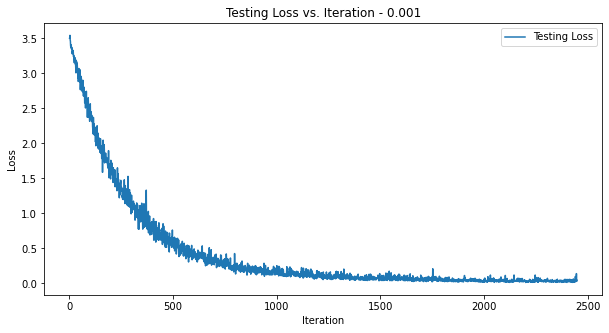

Epoch 0, Iteration 100, loss = 3.4657
Got 357 / 8700 correct (4.10)

Epoch 0, Iteration 200, loss = 3.4327
Got 379 / 8700 correct (4.36)

Epoch 0, Iteration 300, loss = 3.4239
Got 397 / 8700 correct (4.56)

Epoch 0, Iteration 400, loss = 3.3493
Got 446 / 8700 correct (5.13)

Epoch 0, Iteration 500, loss = 3.2658
Got 559 / 8700 correct (6.43)

Epoch 0, Iteration 600, loss = 3.2744
Got 585 / 8700 correct (6.72)

Epoch 0, Iteration 700, loss = 3.2633
Got 696 / 8700 correct (8.00)

Epoch 0, Iteration 800, loss = 3.2738
Got 764 / 8700 correct (8.78)

Epoch 0, Iteration 900, loss = 3.2605
Got 854 / 8700 correct (9.82)

Epoch 0, Iteration 1000, loss = 3.1900
Got 954 / 8700 correct (10.97)

Epoch 0, Iteration 1100, loss = 3.2479
Got 994 / 8700 correct (11.43)

Epoch 0, Iteration 1200, loss = 3.2065
Got 1019 / 8700 correct (11.71)

Epoch 1, Iteration 100, loss = 3.2225
Got 1092 / 8700 correct (12.55)

Epoch 1, Iteration 200, loss = 3.1434
Got 1123 / 8700 correct (12.91)

Epoch 1, Iteration 300,

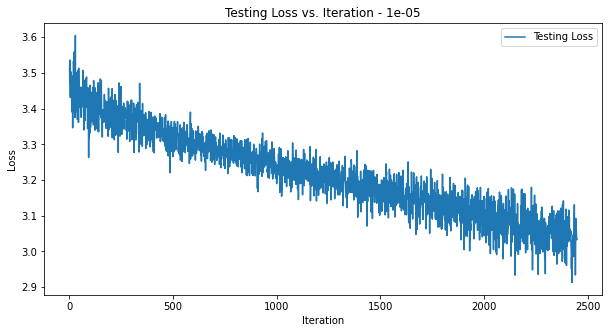

In [54]:
learningrate = [1e-3,1e-5]
channel_1 = 32
channel_2 = 16

for learning_rate in learningrate:
    final_test = DataLoader(test_data, batch_size=64, shuffle=False)  
    train_dataloaderskeleton = DataLoader(train_data, batch_size=64, shuffle=True)
#####################################If needing to change NN#####    
    model = ResNet(num_class = num_class,batch_norm= True)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                         momentum=0.9, nesterov=True)

###############################################################################
    final_accuracy, iterations, losses = train_part34(model, optimizer, epochs=2)
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, losses, label='Testing Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Testing Loss vs. Iteration - {learning_rate}')
    plt.legend()
    plt.show()

# Varying Hyper Parameters

In [16]:
train_dataset = CustomImageDataset(
    img_dir= img_directory, 
    transform=train_transform, 
    mode='train'
)
# Calculate the sizes for training and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset
train_data, test_data = random_split(train_dataset, [train_size, val_size])
train_dataloaderskeleton = DataLoader(train_data, batch_size=64, shuffle=True)
final_test = DataLoader(test_data, batch_size=64, shuffle=False)  


In [17]:
class InterimBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, batch_norm=False):
        super(InterimBlock, self).__init__()
        if batch_norm:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(out_channels) 
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = nn.BatchNorm2d(out_channels)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
            self.bn1 = nn.Identity()
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = nn.Identity()
        

        self.skip = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity()
            )


    def forward(self, x):
        residual = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.skip(residual)
        out = F.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, num_class, batch_norm=True):
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64) if batch_norm else nn.Identity()

        self.conv2_x = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            InterimBlock(64, 64, batch_norm=batch_norm),
            InterimBlock(64, 64, batch_norm=batch_norm)
        )

        self.conv3_x = nn.Sequential(
            InterimBlock(64, 128, batch_norm=batch_norm),
            InterimBlock(128, 128, batch_norm=batch_norm)
        )

        self.conv4_x = nn.Sequential(
            InterimBlock(128, 256, batch_norm=batch_norm),
            InterimBlock(256, 256, batch_norm=batch_norm)
        )

        self.conv5_x = nn.Sequential(
            InterimBlock(256, 512, batch_norm=batch_norm),
            InterimBlock(512, 512, batch_norm=batch_norm)
        )

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_class)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

Epoch 0, Iteration 100, loss = 2.5415
Got 1829 / 8700 correct (21.02)

Epoch 0, Iteration 200, loss = 1.5468
Got 3006 / 8700 correct (34.55)

Epoch 0, Iteration 300, loss = 1.2614
Got 3717 / 8700 correct (42.72)

Epoch 0, Iteration 400, loss = 1.0747
Got 4264 / 8700 correct (49.01)

Epoch 0, Iteration 500, loss = 0.7264
Got 4673 / 8700 correct (53.71)

Epoch 0, Iteration 600, loss = 0.4281
Got 4127 / 8700 correct (47.44)

Epoch 0, Iteration 700, loss = 0.3087
Got 6653 / 8700 correct (76.47)

Epoch 0, Iteration 800, loss = 0.2743
Got 7930 / 8700 correct (91.15)

Epoch 0, Iteration 900, loss = 0.2424
Got 6653 / 8700 correct (76.47)

Epoch 0, Iteration 1000, loss = 0.3007
Got 7988 / 8700 correct (91.82)

Epoch 0, Iteration 1100, loss = 0.1341
Got 8496 / 8700 correct (97.66)

Epoch 0, Iteration 1200, loss = 0.0897
Got 8365 / 8700 correct (96.15)

Epoch 1, Iteration 100, loss = 0.0612
Got 8599 / 8700 correct (98.84)

Epoch 1, Iteration 200, loss = 0.1024
Got 8293 / 8700 correct (95.32)

Epo

NameError: name 'batch_size' is not defined

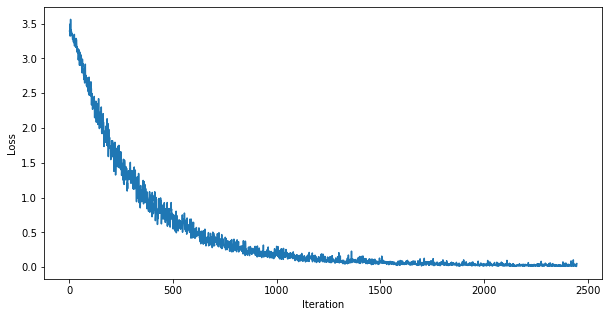

In [18]:
 model = ResNet(num_class = num_class,batch_norm= True)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

final_accuracy, iterations, losses = train_part34(model, optimizer, epochs=2)
plt.figure(figsize=(10, 5))
plt.plot(iterations, losses, label='Testing Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title(f'Testing Loss vs. Iteration - 64')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(iterations, final_accuracy, label='Testing accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title(f'Testing Accuracy vs. Iteration - 64')
plt.legend()
plt.show()

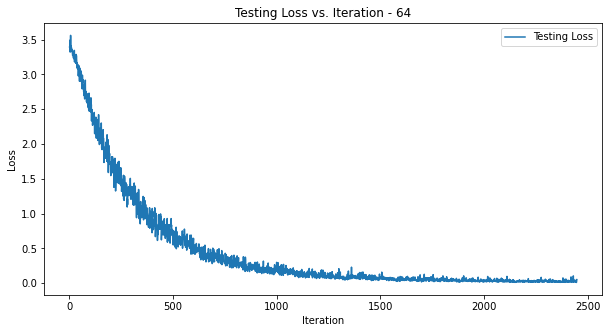

0.993448275862069


ValueError: x and y must have same first dimension, but have shapes (2448,) and (1,)

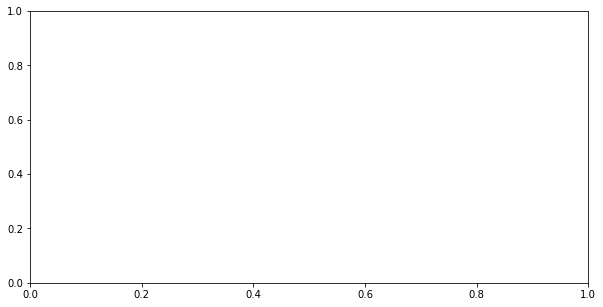

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(iterations, losses, label='Testing Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title(f'Testing Loss vs. Iteration - 64')
plt.legend()
plt.show()


In [ ]:
batchsize = [128,256]
channel_1 = 32
channel_2 = 16

for batch_size in batchsize:
    final_test = DataLoader(test_data, batch_size=batch_size, shuffle=False)  
    train_dataloaderskeleton = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model = ResNet(num_class = num_class,batch_norm= True)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)
    
    final_accuracy, iterations, losses = train_part34(model, optimizer, epochs=2)
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, losses, label='Training Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Training Loss vs. Iteration - {batch_size}')
    plt.legend()
    plt.show()




# Varying Learning Rate

Epoch 0, Iteration 100, loss = 2.6102
Got 872 / 8700 correct (10.02)

Epoch 0, Iteration 200, loss = 1.8975
Got 929 / 8700 correct (10.68)

Epoch 0, Iteration 300, loss = 0.9672
Got 2315 / 8700 correct (26.61)

Epoch 0, Iteration 400, loss = 0.5519
Got 6615 / 8700 correct (76.03)

Epoch 0, Iteration 500, loss = 0.2441
Got 6731 / 8700 correct (77.37)

Epoch 0, Iteration 600, loss = 0.1496
Got 6873 / 8700 correct (79.00)

Epoch 0, Iteration 700, loss = 0.2192
Got 3020 / 8700 correct (34.71)

Epoch 0, Iteration 800, loss = 0.0971
Got 7893 / 8700 correct (90.72)

Epoch 0, Iteration 900, loss = 0.0551
Got 6058 / 8700 correct (69.63)

Epoch 0, Iteration 1000, loss = 0.0804
Got 7146 / 8700 correct (82.14)

Epoch 0, Iteration 1100, loss = 0.0491
Got 8452 / 8700 correct (97.15)

Epoch 0, Iteration 1200, loss = 0.0489
Got 7988 / 8700 correct (91.82)

Epoch 1, Iteration 100, loss = 0.0503
Got 8244 / 8700 correct (94.76)

Epoch 1, Iteration 200, loss = 0.0140
Got 8568 / 8700 correct (98.48)

Epoch

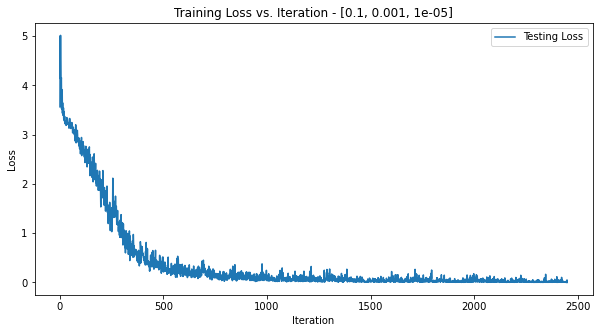

Epoch 0, Iteration 100, loss = 2.4932
Got 1239 / 8700 correct (14.24)

Epoch 0, Iteration 200, loss = 1.7283
Got 4494 / 8700 correct (51.66)

Epoch 0, Iteration 300, loss = 1.2003
Got 1084 / 8700 correct (12.46)

Epoch 0, Iteration 400, loss = 1.0676
Got 4690 / 8700 correct (53.91)

Epoch 0, Iteration 500, loss = 0.6721
Got 5864 / 8700 correct (67.40)

Epoch 0, Iteration 600, loss = 0.4319
Got 5929 / 8700 correct (68.15)

Epoch 0, Iteration 700, loss = 0.4734
Got 2012 / 8700 correct (23.13)

Epoch 0, Iteration 800, loss = 0.2819
Got 5676 / 8700 correct (65.24)

Epoch 0, Iteration 900, loss = 0.2424
Got 6796 / 8700 correct (78.11)

Epoch 0, Iteration 1000, loss = 0.2020
Got 8444 / 8700 correct (97.06)

Epoch 0, Iteration 1100, loss = 0.1075
Got 8054 / 8700 correct (92.57)

Epoch 0, Iteration 1200, loss = 0.1118
Got 7826 / 8700 correct (89.95)

Epoch 1, Iteration 100, loss = 0.0603
Got 7890 / 8700 correct (90.69)

Epoch 1, Iteration 200, loss = 0.0870
Got 8160 / 8700 correct (93.79)

Epo

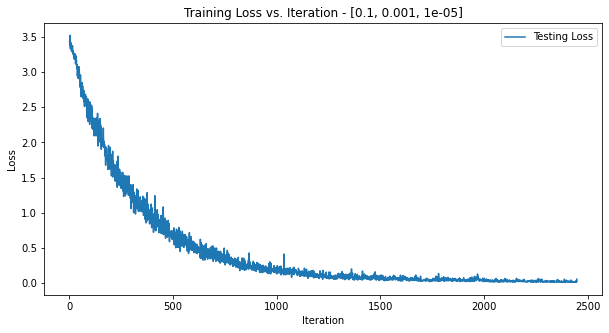

Epoch 0, Iteration 100, loss = 3.4646
Got 314 / 8700 correct (3.61)

Epoch 0, Iteration 200, loss = 3.4225
Got 314 / 8700 correct (3.61)

Epoch 0, Iteration 300, loss = 3.3376
Got 314 / 8700 correct (3.61)

Epoch 0, Iteration 400, loss = 3.3331
Got 318 / 8700 correct (3.66)

Epoch 0, Iteration 500, loss = 3.3814
Got 376 / 8700 correct (4.32)

Epoch 0, Iteration 600, loss = 3.3657
Got 561 / 8700 correct (6.45)

Epoch 0, Iteration 700, loss = 3.2786
Got 668 / 8700 correct (7.68)

Epoch 0, Iteration 800, loss = 3.3277
Got 752 / 8700 correct (8.64)

Epoch 0, Iteration 900, loss = 3.2758
Got 914 / 8700 correct (10.51)

Epoch 0, Iteration 1000, loss = 3.2813
Got 1055 / 8700 correct (12.13)

Epoch 0, Iteration 1100, loss = 3.2254
Got 1127 / 8700 correct (12.95)

Epoch 0, Iteration 1200, loss = 3.2035
Got 1222 / 8700 correct (14.05)

Epoch 1, Iteration 100, loss = 3.2826
Got 1264 / 8700 correct (14.53)

Epoch 1, Iteration 200, loss = 3.2047
Got 1274 / 8700 correct (14.64)

Epoch 1, Iteration 3

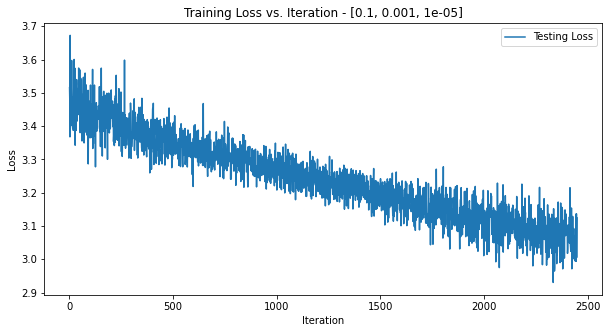

In [31]:
learningrate = [1e-1,1e-3,1e-5]
channel_1 = 32
channel_2 = 16

for learning_rate in learningrate:
    train_dataloaderskeleton = DataLoader(train_data, batch_size=64, shuffle=True)
    final_test = DataLoader(test_data, batch_size=64, shuffle=False)  
#####################################If needing to change NN#####    
    model = ResNet(num_class = num_class,batch_norm= True)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                         momentum=0.9, nesterov=True)

###############################################################################
    final_accuracy, iterations, losses = train_part34(model, optimizer, epochs=2)
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, losses, label='Testing Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Training Loss vs. Iteration - {learningrate}')
    plt.legend()
    plt.show()


# Complete accuracy count comparison between 3 and 4 channel

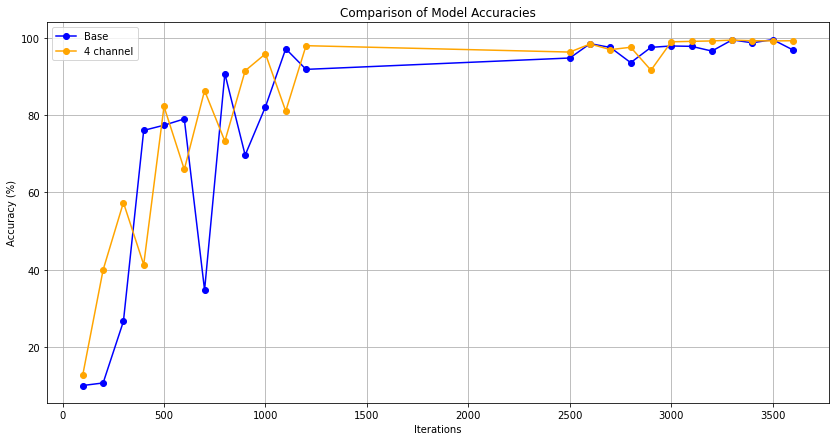

In [55]:
import matplotlib.pyplot as plt

# Data for "Base" accuracy
base_iterations = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400]
base_accuracies = [10.02, 10.68, 26.61, 76.03, 77.37, 79.00, 34.71, 90.72, 69.63, 82.14, 97.15, 91.82, 94.76, 98.48, 97.49, 93.56, 97.52, 97.87, 97.78, 96.56, 99.45, 98.69, 99.53, 96.84]

# Data for "4 channel" accuracy
channel4_iterations = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400]
channel4_accuracies = [12.85, 39.95, 57.36, 41.29, 82.23, 65.92, 86.32, 73.22, 91.46, 95.84, 81.02, 97.95, 96.30, 98.39, 96.93, 97.54, 91.60, 98.95, 99.07, 99.18, 99.39, 99.24, 99.18, 99.23]

# Adjust the iteration numbers for the second epoch to follow the first epoch
for i in range(12, 24):
    base_iterations[i] += 1200
    channel4_iterations[i] += 1200

# Plotting the graph
plt.figure(figsize=(14, 7))
plt.plot(base_iterations, base_accuracies, 'o-', color='blue', label='Base')
plt.plot(channel4_iterations, channel4_accuracies, 'o-', color='orange', label='4 channel')
plt.title('Comparison of Model Accuracies')
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


# 

# Analysis of Results

# RUN THIS PART AWEHRAEFHIAEHAFIEHFAFKLAWEHRAEFHIAEHAFIEHFAFKLAWEHRAEFHIAEHAFIEHFAFKLAWEHRAEFHIAEHAFIEHFAFKLAWEHRAEFHIAEHAFIEHFAFKLAWEHRAEFHIAEHAFIEHFAFKL
trying on the other dataset
first one is without skeleton

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None, mode='train'):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.mode = mode
        self.img_labels = self._get_image_labels()


    def _get_image_labels(self):
        img_labels = []
        if self.mode == 'train':
            label = 0
            for root, dirs, files in os.walk(self.img_dir):
                for subdir in sorted(dirs):
                    subdir_path = os.path.join(root, subdir)
                    for _, _, files in os.walk(subdir_path):
                        for file in files:
                            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                                img_labels.append((os.path.join(subdir, file), label))
                    label += 1
        elif self.mode == 'test':
            for root, _, files in os.walk(self.img_dir):
                for file in files:
                    if file.lower().endswith(('png', 'jpg', 'jpeg')):
                        img_labels.append((file, None))
        return img_labels

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        img_path = os.path.join(self.img_dir, img_path)
        image = Image.open(img_path).convert('RGB')  # Use PIL to open image
        if self.transform:
            image = self.transform(image)
        if self.target_transform and label is not None:
            label = self.target_transform(label)
        return image, label



class CustomNewImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.default_transform = transforms.Compose([
            transforms.Resize((200, 200)),  # Resize all images to 200x200
            transforms.ToTensor()
        ])
        self.transform = transform if transform is not None else self.default_transform
        self.img_labels = []

        directories = sorted(os.listdir(img_dir))  # Ensure alphabetical order
        for label, subdir in enumerate(directories):
            subdir_path = os.path.join(img_dir, subdir)
            if os.path.isdir(subdir_path):
                for file in sorted(os.listdir(subdir_path)):
                    if file.lower().endswith(('png', 'jpg', 'jpeg')):
                        self.img_labels.append((os.path.join(subdir_path, file), label))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        return image, label

In [ ]:
class InterimBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, batch_norm=False):
        super(InterimBlock, self).__init__()
        if batch_norm:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(out_channels) 
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = nn.BatchNorm2d(out_channels)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
            self.bn1 = nn.Identity()
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = nn.Identity()
        

        self.skip = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity()
            )


    def forward(self, x):
        residual = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.skip(residual)
        out = F.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, num_class, batch_norm=True):
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64) if batch_norm else nn.Identity()

        self.conv2_x = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            InterimBlock(64, 64, batch_norm=batch_norm),
            InterimBlock(64, 64, batch_norm=batch_norm)
        )

        self.conv3_x = nn.Sequential(
            InterimBlock(64, 128, batch_norm=batch_norm),
            InterimBlock(128, 128, batch_norm=batch_norm)
        )

        self.conv4_x = nn.Sequential(
            InterimBlock(128, 256, batch_norm=batch_norm),
            InterimBlock(256, 256, batch_norm=batch_norm)
        )

        self.conv5_x = nn.Sequential(
            InterimBlock(256, 512, batch_norm=batch_norm),
            InterimBlock(512, 512, batch_norm=batch_norm)
        )

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_class)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:

# Create data loaders for the training and validation sets
train_dataset = CustomImageDataset(
    img_dir= img_directory, 
    transform=train_transform,
    mode='train'
)
test_dataset = CustomNewImageDataset(
    img_dir= img_dir, 

)
train_dataloaderskeleton = DataLoader(train_dataset, batch_size=64, shuffle=True)
final_test = DataLoader(test_dataset, batch_size=64, shuffle=True)


In [ ]:
 model = ResNet(num_class = num_class,batch_norm= True)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

final_accuracy, iterations, losses = train_part34(model, optimizer, epochs=2)

In [ ]:
class InterimBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, batch_norm=False):
        super(InterimBlock, self).__init__()
        if batch_norm:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(out_channels) 
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = nn.BatchNorm2d(out_channels)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
            self.bn1 = nn.Identity()
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = nn.Identity()
        

        self.skip = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity()
            )


    def forward(self, x):
        residual = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.skip(residual)
        out = F.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, num_class, batch_norm=True):
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64) if batch_norm else nn.Identity()

        self.conv2_x = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            InterimBlock(64, 64, batch_norm=batch_norm),
            InterimBlock(64, 64, batch_norm=batch_norm)
        )

        self.conv3_x = nn.Sequential(
            InterimBlock(64, 128, batch_norm=batch_norm),
            InterimBlock(128, 128, batch_norm=batch_norm)
        )

        self.conv4_x = nn.Sequential(
            InterimBlock(128, 256, batch_norm=batch_norm),
            InterimBlock(256, 256, batch_norm=batch_norm)
        )

        self.conv5_x = nn.Sequential(
            InterimBlock(256, 512, batch_norm=batch_norm),
            InterimBlock(512, 512, batch_norm=batch_norm)
        )

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_class)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

## Doing it on training dataset where there is skeleton



In [ ]:

class CustomNewImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.default_transform = transforms.Compose([
            transforms.Resize((200, 200)),  # Resize all images to 200x200
            transforms.ToTensor()
        ])
        self.transform = transform if transform is not None else self.default_transform
        self.img_labels = []

        directories = sorted(os.listdir(img_dir))  # Ensure alphabetical order
        for label, subdir in enumerate(directories):
            subdir_path = os.path.join(img_dir, subdir)
            if os.path.isdir(subdir_path):
                for file in sorted(os.listdir(subdir_path)):
                    if file.lower().endswith(('png', 'jpg', 'jpeg')):
                        self.img_labels.append((os.path.join(subdir_path, file), label))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Assume the transformed image is a 3-channel image of shape CxHxW
        # Add a dummy fourth channel
        dummy_channel = torch.zeros_like(image[0, :, :]).unsqueeze(0)  # Create a new channel with the same HxW dimensions
        image = torch.cat((image, dummy_channel), dim=0)  # Concatenate the dummy channel
        
        return image, label

# Create data loaders for the training and validation sets
train_datasetskeleton = CustomImageDatasetSkele(
    img_dir= img_directory, 
    skeleton_dir = img_skeleton,
    #skeleton_dir ='/home/sdcastaneda/skeleton/skeletonimages',
    transform=train_transform,
    mode='train'
)

test_dataset = CustomNewImageDataset(
    img_dir= img_dir,
    transform=train_transform
)
train_dataloaderskeleton = DataLoader(train_dataset, batch_size=64, shuffle=True)
final_test = CustomNewImageDataset(img_dir=img_dir, transform=transform)


In [ ]:
 model = ResNet(num_class = num_class,batch_norm= True)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

final_accuracy, iterations, losses = train_part34(model, optimizer, epochs=2)